# K-fold cross-validation

**Group D**:

    - Ashvin Alex
    - Bastian Castillo
    - Marcelo Munoz
    - Sabin Pokhrel

In our previous analysis of Walmart Sales, we focused on removing outliers, evaluating the most meaningful features through RFE (Recursive Feature Elimination) and Feature Engineering, aggregating data and using it to create new historical features to provide more relevant data for the model. We concluded that it was necessary to continue doing other analyses of this dataset changes to determine if our model was memorizing the data (overfitting). In this document, we applied a K-Fold Cross Validation to take advantage of all variability of the data to use it to train and test the model.

### Importing libraries

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from numpy import array
from numpy import mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
import pickle

### Defining helper functions

The following functions were used in our previous analysis. Here is the detail of each of them.

- **compute_ratio**: calculates the ratio of missing values.
- **remove_outliers**: remove the data by indicating the number of standard deviations.
- **get_previous_aggregated_sales**: it aggregates the previous week's sales and adds it to a new column in the data frame.

In [3]:
def compute_ratio(dataset, columns):
  """
  Computes the ratio of missing values.

  Parameters
  ---------
  dataframe: Pandas DataFrame
    dataset
  colums: list
    array names of columns.

  Returns
  ----------
  dataframe: Pandas DataFrame
    a dataset with compute ratio for each feature
  """

  Rms = {}
  for col in columns:
    Rm = dataset[col].isnull().sum() / dataset[col].count()
    Rms[col] = Rm

  Rms = pd.DataFrame(Rms.items(), columns=['Feature', 'Rm'])

  return Rms 

In [4]:
def remove_outliers(dataframe, columns, nsd):
  """
  Revome outliers from a given dataset.

  Parameters
  ---------
  dataframe: Pandas DataFrame
    dataset
  colums: list
    array names of columns.
  nsd: int
    number of standar deviation.

  Returns
  ----------
  dataframe: Pandas DataFrame
    a dataset without outliers
  """
  for col in columns:
    
    mean = dataframe[col].mean()
    sd = dataframe[col].std()
    dataframe = dataframe[dataframe[col] < mean + (nsd * sd)]

  return dataframe

In [5]:
def get_previous_aggregated_sales(data, number_of_weeks, field_name):
    """
    Sums the Weekly Sales previous numbers of weeks indicated in 
    the number_of weeks_parameter. The process sums the weeks by stores
    and before doing the addition it orders the records in a decendend way.
    Then it concats all the stores in a unified dataet.

    Parameters
    ---------

    data: Pandas Dataframe
      Dataset to modify
    
    number_of_weeks: int
      Previous number of weeks to consider to addition
    
    field_name: str
      Number of the new field that contains the sum of previous weeks

    Returns
    ---------

    Dataframe with the new field
    """
    ds = data.copy(deep=True)
    stores = list(range(ds['Store'].min(), ds['Store'].max() + 1))

    process_data = []

    for i in stores:
      data_store = ds[ds['Store'] == i].copy(deep=True)
      data_store.sort_values(by='Date', ascending=False, inplace=True)
      data_store[field_name] = data_store['Weekly_Sales'].rolling(number_of_weeks).sum().shift(-1 * number_of_weeks)

      process_data.append(data_store)

    process_data = pd.concat(process_data)

    
    return process_data

### Loading dataset

We stored the dataset in a GitHub repository, and it loaded into a Data Frame object. The date feature is parsed to DateTime. After that, 20% of the data is reserved for validation after applying cross-validation to measure the model's performance against new data.

In [16]:
url = 'https://raw.githubusercontent.com/bascr/walmart-sales/main/dataset/walmart-sales.csv'
dataset_ = pd.read_csv(url)
dataset_['Date'] = pd.to_datetime(dataset_['Date'], format='%d-%m-%Y')

dataset = dataset_.sample(frac=0.8,random_state=1)
validation_dataset = dataset_.drop(dataset.index)

dataset

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
447,4,2010-06-11,1870619.23,0,78.45,2.668,126.111903,7.896
2196,16,2011-01-28,448391.99,0,20.80,3.008,191.667891,6.614
3253,23,2012-02-24,1272948.27,0,31.12,3.751,137.341103,4.261
2873,21,2010-05-07,744969.42,0,70.87,2.835,210.001102,8.200
712,5,2012-10-12,325345.41,0,66.24,3.601,223.974787,5.422
...,...,...,...,...,...,...,...,...
2817,20,2012-01-06,1964701.94,0,33.42,3.422,212.571112,6.961
6247,44,2011-12-23,376233.89,0,24.76,3.186,129.984548,6.078
618,5,2010-12-24,466010.25,0,55.01,2.886,211.957398,6.768
2381,17,2011-11-18,877724.31,0,32.93,3.489,129.826833,6.617


According to our previous analysis, the same steps are applied. In this case,  we create two new columns containing the aggregated sales from the last two and four weeks per each record.

In [17]:
dataset = get_previous_aggregated_sales(dataset, 2, 'Sales2WB')
dataset = get_previous_aggregated_sales(dataset, 4, 'Sales4WB')
dataset

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Sales2WB,Sales4WB
142,1,2012-10-26,1493659.74,0,69.16,3.506,223.444251,6.573,3081141.58,6188986.81
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573,3243858.78,6187044.10
140,1,2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573,3107845.23,6131400.16
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573,2943185.32,6122381.52
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908,3023554.93,6267405.66
...,...,...,...,...,...,...,...,...,...,...
6298,45,2010-03-19,773819.49,0,48.79,2.844,182.077986,8.992,1543638.64,3275592.19
6297,45,2010-03-12,765687.42,0,45.80,2.818,182.162844,8.992,1619215.26,NaN
6296,45,2010-03-05,777951.22,0,37.13,2.777,182.120157,8.992,1731953.55,NaN
6294,45,2010-02-19,841264.04,0,31.27,2.745,182.034782,8.992,NaN,NaN


Because there is a point where there is no previous data, now our Data Frame has NaN values. Because the computed ratio is low, the NaN values are imputed using the mean from the respective column. After this, the computed ratio is calculated again, and there are no NaN values, as you can see in the following table.

In [18]:
dataset['Sales2WB'] = dataset['Sales2WB'].fillna(dataset['Sales2WB'].mean())
dataset['Sales4WB'] = dataset['Sales4WB'].fillna(dataset['Sales4WB'].mean())

Rms = compute_ratio(dataset, ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'])
Rms

,Feature,Rm
0,Weekly_Sales,0.0
1,Temperature,0.0
2,Fuel_Price,0.0
3,CPI,0.0
4,Unemployment,0.0
5,Sales2WB,0.0
6,Sales4WB,0.0


### Recursive Feature Elimination (RFE)

In the next piece of code, an RFC algorithm is used to select the meaningful features in our model. So the algorithm iterates recursively, applying a Regression model to choose the six most meaningful features according to the best score obtained. Previously to use RFE, we parse the date from DateTime to Timestamp (number). We removed the 
data points beyond three standard deviations. We provide all the features and the target and use the RFE algorithm. As a result, the essential features are returned. 

In [19]:
dataset = dataset.copy(deep=True)
dataset = dataset[dataset['Date'].dt.month != 12]
number_of_features=6
number_of_sd = 3

dataset['Date'] = dataset['Date'].map(datetime.datetime.toordinal)

dataset = remove_outliers(dataset, ['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'], number_of_sd)

X = dataset[['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB']]
y = dataset['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regr = LinearRegression()
selector = RFE(regr, n_features_to_select=number_of_features)
selector = selector.fit(X_train, y_train)

filter = selector.support_
ranking = selector.ranking_

features = array(['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'])
print('Selected features:')
print(features[filter])

Selected features:
['Store' 'Date' 'Temperature' 'Fuel_Price' 'Sales2WB' 'Sales4WB']


## Cross-Validation: K-fold implementation

In the next cell, a function that implements the k-fold algorithm is applied using 4, 6 and 10 folds. This way, we wanted to evaluate the performance of our model and the changes we made in our Data Frame by training and testing it over the entire Data Frame changing the variation of the data.  The function receives the number of folds and the features and the target as Data Frame objects.

### Function definition

In [53]:
def k_fold_impl(n_folds, ds_X, ds_y):

    # split using kfold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    regr = LinearRegression()

    k_iteration = 1
    r2_score_lists = []

    for train_index, test_index in kf.split(ds_X):

        print(f'Fold N° {k_iteration}\n')

        X_train, X_test = ds_X.iloc[train_index], ds_X.iloc[test_index]
        y_train, y_test = ds_y.iloc[train_index], ds_y.iloc[test_index]

        sc = StandardScaler()

        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        regr.fit(X_train, y_train)

        print(f"Training set: {len(X_train)} rows.")
        print(f"Testing set: {len(X_test)} rows.\n")
        print(f"Interceptor value: {regr.intercept_}")
        print(f"Slope or coefficient value: {regr.coef_}\n")

        y_pred = regr.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred) * 100
        r2_score_lists.append(r2)

        print(f'Mean Absolute Error: { mae:.2f}')
        print(f'Mean Squared Error: {mse:.2f}')
        print(f'Root Mean Squared Error: {rmse:.2f}')
        print(f'R2 Score: {r2:.2f}%\n')
        
        sns.scatterplot(x=range(len(y_test)), y=y_test, color='blue')
        sns.scatterplot(x=range(len(y_pred)), y=y_pred, color='red')
        plt.title(f'Actual vs Predicted values Fold N° {k_iteration}')
        
        plt.show()

        k_iteration +=1

    r2_score_mean = mean(r2_score_lists)
    print(f'\nMean Accuracy over all cross-validation: {r2_score_mean:.2f}%')
    
    # Saving the model
    filename = f'{k_iteration - 1}_fold_model.sav'
    pickle.dump(regr, open(filename, 'wb'))
    

### 4 folds

Application of the cross-validation algorithm using 4 folds.

Fold N° 1

Training set: 3267 rows.
Testing set: 1089 rows.

Interceptor value: 1017808.0260208149
Slope or coefficient value: [ -4214.83576206 -14188.18961238   9990.11276411  13945.11836712
 437683.37307457  78425.38478789]

Mean Absolute Error: 67636.16
Mean Squared Error: 13681310198.46
Root Mean Squared Error: 116967.13
R2 Score: 95.18%



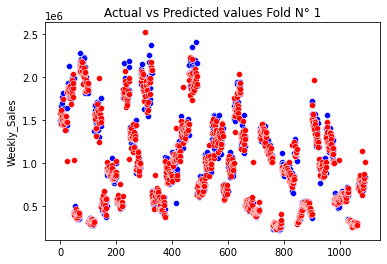

Fold N° 2

Training set: 3267 rows.
Testing set: 1089 rows.

Interceptor value: 1022464.9237557393
Slope or coefficient value: [ -5370.25911876  -9200.39933847   8789.37819101   9439.56920186
 441117.37576667  75755.74321268]

Mean Absolute Error: 74240.90
Mean Squared Error: 18453520757.31
Root Mean Squared Error: 135843.74
R2 Score: 93.50%



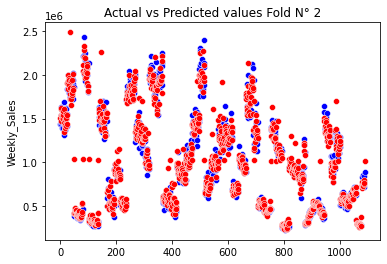

Fold N° 3

Training set: 3267 rows.
Testing set: 1089 rows.

Interceptor value: 1022363.37792776
Slope or coefficient value: [ -5480.20315427 -14104.02451355  11627.18747897  13012.87637842
 447137.76838215  73118.50530539]

Mean Absolute Error: 65945.27
Mean Squared Error: 12771058750.89
Root Mean Squared Error: 113009.11
R2 Score: 95.25%



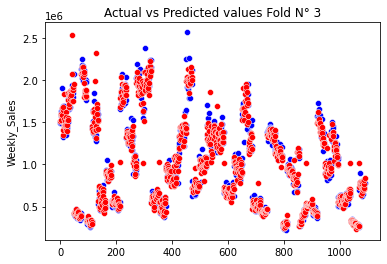

Fold N° 4

Training set: 3267 rows.
Testing set: 1089 rows.

Interceptor value: 1016809.2308172631
Slope or coefficient value: [ -5881.84790631 -13330.54206311  13048.0162191   14165.49700249
 436802.55190025  76419.18776129]

Mean Absolute Error: 63951.39
Mean Squared Error: 11269884407.63
Root Mean Squared Error: 106159.71
R2 Score: 96.10%



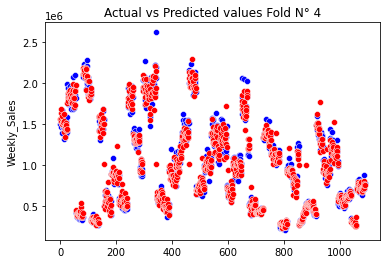


Mean Accuracy over all cross-validation: 95.01%


In [54]:
dataset_1 = dataset.copy(deep=True)
n_folds = 4
features = dataset_1[['Store', 'Date', 'Temperature', 'Fuel_Price', 'Sales2WB', 'Sales4WB']]
target = dataset_1['Weekly_Sales']

k_fold_impl(n_folds=n_folds, ds_X=features, ds_y=target)

### 6 folds
Application of the cross-validation algorithm using 6 folds.

Fold N° 1

Training set: 3630 rows.
Testing set: 726 rows.

Interceptor value: 1019181.1452203853
Slope or coefficient value: [ -4361.22731811 -13361.7823174    9466.18828086  12656.08322556
 438008.503512    78366.00085819]

Mean Absolute Error: 71283.98
Mean Squared Error: 16522795869.72
Root Mean Squared Error: 128541.03
R2 Score: 94.23%



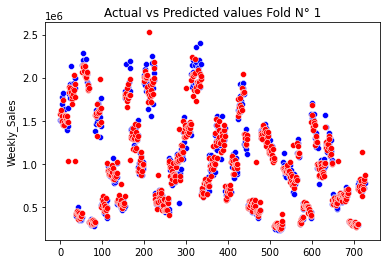

Fold N° 2

Training set: 3630 rows.
Testing set: 726 rows.

Interceptor value: 1019326.4039531699
Slope or coefficient value: [ -5160.27975458 -11927.6274562   11829.44484945  12685.26016884
 442625.84327916  72477.59197045]

Mean Absolute Error: 64837.44
Mean Squared Error: 12522166567.19
Root Mean Squared Error: 111902.49
R2 Score: 95.63%



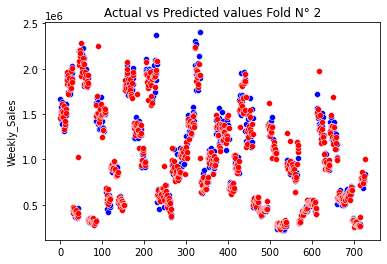

Fold N° 3

Training set: 3630 rows.
Testing set: 726 rows.

Interceptor value: 1021571.7731818182
Slope or coefficient value: [ -5297.35400985 -10981.5927994    8699.4063072   10854.77112754
 438974.91681122  79172.56233663]

Mean Absolute Error: 76868.14
Mean Squared Error: 19129231559.31
Root Mean Squared Error: 138308.47
R2 Score: 93.12%



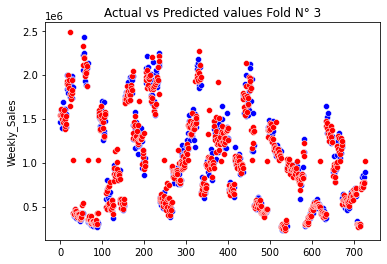

Fold N° 4

Training set: 3630 rows.
Testing set: 726 rows.

Interceptor value: 1020407.8776308512
Slope or coefficient value: [ -5465.8853934  -14340.6547416   11186.48581928  14008.90993879
 444430.29090946  73944.56527674]

Mean Absolute Error: 64640.78
Mean Squared Error: 13057090914.69
Root Mean Squared Error: 114267.63
R2 Score: 95.18%



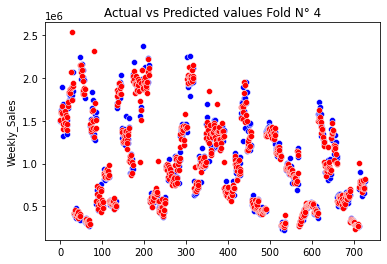

Fold N° 5

Training set: 3630 rows.
Testing set: 726 rows.

Interceptor value: 1020042.4702975212
Slope or coefficient value: [ -5821.33796341 -11494.43603063  13008.46891434  11701.58977184
 442428.28029999  75849.15877179]

Mean Absolute Error: 66925.41
Mean Squared Error: 14056415236.19
Root Mean Squared Error: 118559.75
R2 Score: 94.84%



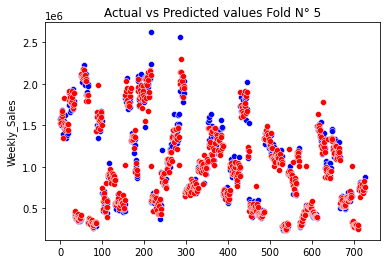

Fold N° 6

Training set: 3630 rows.
Testing set: 726 rows.

Interceptor value: 1018638.6674986228
Slope or coefficient value: [ -5169.69627347 -14084.10516357  11050.90397673  13897.02409876
 437562.91575512  75839.79298755]

Mean Absolute Error: 63245.43
Mean Squared Error: 8942804417.80
Root Mean Squared Error: 94566.40
R2 Score: 96.95%



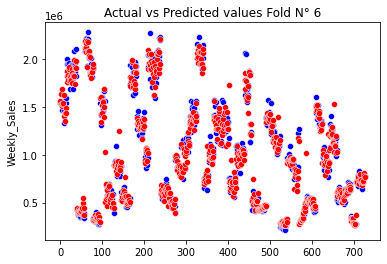


Mean Accuracy over all cross-validation: 94.99%


In [55]:
dataset_1 = dataset.copy(deep=True)
n_folds = 6
features = dataset_1[['Store', 'Date', 'Temperature', 'Fuel_Price', 'Sales2WB', 'Sales4WB']]
target = dataset_1['Weekly_Sales']

k_fold_impl(n_folds=n_folds, ds_X=features, ds_y=target)

### 10 folds
Application of the cross-validation algorithm using 10 folds.

Fold N° 1

Training set: 3920 rows.
Testing set: 436 rows.

Interceptor value: 1017641.9114438769
Slope or coefficient value: [ -4925.62463897 -12161.39295131   9879.58414142  11538.95654388
 437140.83040278  79329.4678483 ]

Mean Absolute Error: 69865.95
Mean Squared Error: 16189880954.05
Root Mean Squared Error: 127239.46
R2 Score: 94.36%



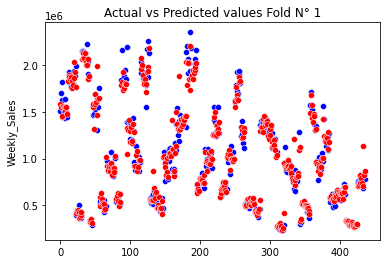

Fold N° 2

Training set: 3920 rows.
Testing set: 436 rows.

Interceptor value: 1018715.2159744921
Slope or coefficient value: [ -4527.56744768 -13796.85822721  10680.75660648  13694.45936404
 440358.37748235  75492.31914453]

Mean Absolute Error: 71861.01
Mean Squared Error: 14910926866.40
Root Mean Squared Error: 122110.31
R2 Score: 94.86%



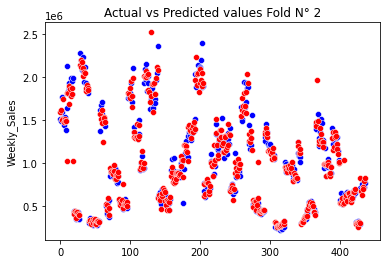

Fold N° 3

Training set: 3920 rows.
Testing set: 436 rows.

Interceptor value: 1021674.0823494917
Slope or coefficient value: [ -5294.3385586  -12096.92236997  11658.91133671  13131.98096454
 443467.41018639  73881.59049715]

Mean Absolute Error: 63870.36
Mean Squared Error: 13480699084.16
Root Mean Squared Error: 116106.41
R2 Score: 95.05%



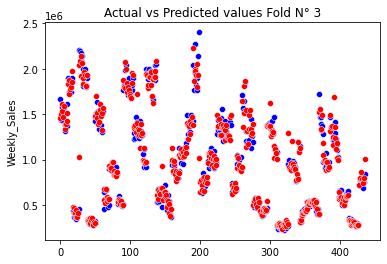

Fold N° 4

Training set: 3920 rows.
Testing set: 436 rows.

Interceptor value: 1022650.9636020421
Slope or coefficient value: [ -5153.95742128 -13056.32224192  10234.57404724  12175.6244164
 439903.74473237  74367.84834454]

Mean Absolute Error: 66210.94
Mean Squared Error: 11360396129.26
Root Mean Squared Error: 106585.16
R2 Score: 96.19%



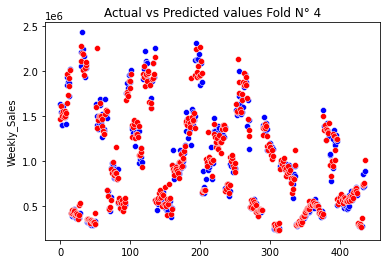

Fold N° 5

Training set: 3920 rows.
Testing set: 436 rows.

Interceptor value: 1019298.8365484679
Slope or coefficient value: [ -5320.1543244  -10723.6844462    9550.96253973  11101.76658454
 440294.52235025  78694.14584299]

Mean Absolute Error: 83249.69
Mean Squared Error: 24267704521.59
Root Mean Squared Error: 155780.95
R2 Score: 90.99%



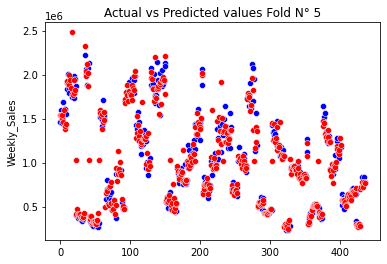

Fold N° 6

Training set: 3920 rows.
Testing set: 436 rows.

Interceptor value: 1021551.7833928572
Slope or coefficient value: [ -5470.01500188 -13130.16188728  10431.68055461  12613.17123096
 445533.56262171  73075.92023665]

Mean Absolute Error: 67664.74
Mean Squared Error: 14992798466.96
Root Mean Squared Error: 122445.08
R2 Score: 94.29%



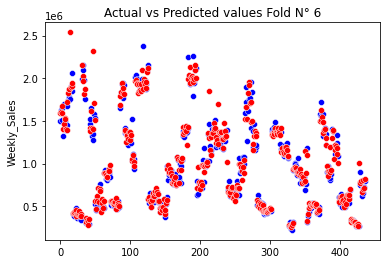

Fold N° 7

Training set: 3921 rows.
Testing set: 435 rows.

Interceptor value: 1019831.0508492723
Slope or coefficient value: [ -5111.50802673 -13644.93891171  12063.83958361  13427.7144188
 437938.47038848  78014.46644905]

Mean Absolute Error: 62564.27
Mean Squared Error: 10373143642.04
Root Mean Squared Error: 101848.63
R2 Score: 96.36%



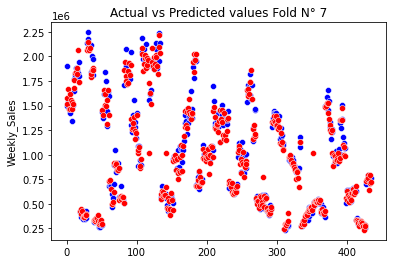

Fold N° 8

Training set: 3921 rows.
Testing set: 435 rows.

Interceptor value: 1017671.7732134642
Slope or coefficient value: [ -6057.74769396 -12082.93994082  11445.13957431  12007.34553692
 441855.54571557  76164.06613182]

Mean Absolute Error: 65338.21
Mean Squared Error: 10735439668.64
Root Mean Squared Error: 103611.97
R2 Score: 95.91%



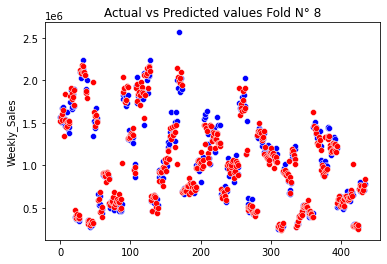

Fold N° 9

Training set: 3921 rows.
Testing set: 435 rows.

Interceptor value: 1020113.0786279007
Slope or coefficient value: [ -4885.9706912  -12700.70990061  10855.54012828  13461.99915869
 444937.71987702  70935.65428827]

Mean Absolute Error: 64435.52
Mean Squared Error: 14975773467.02
Root Mean Squared Error: 122375.54
R2 Score: 94.83%



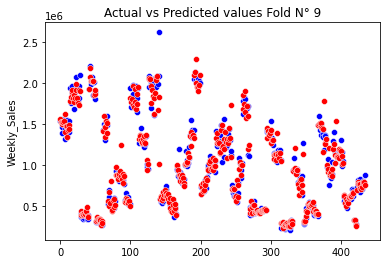

Fold N° 10

Training set: 3921 rows.
Testing set: 435 rows.

Interceptor value: 1019465.8033256847
Slope or coefficient value: [ -5245.88404091 -13565.74551436  11995.93122441  13205.20755088
 435246.47868645  79569.9181319 ]

Mean Absolute Error: 64299.18
Mean Squared Error: 9076764270.39
Root Mean Squared Error: 95272.05
R2 Score: 96.92%



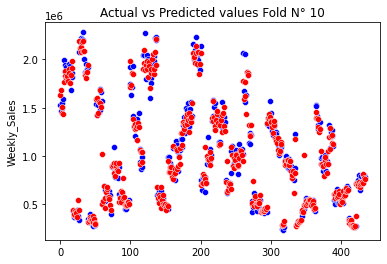


Mean Accuracy over all cross-validation: 94.98%


In [56]:
# define best X:features and y:label
dataset_2 = dataset.copy(deep=True)
n_folds = 10
features = dataset_2[['Store', 'Date', 'Temperature', 'Fuel_Price', 'Sales2WB', 'Sales4WB']]
target = dataset_2['Weekly_Sales']

k_fold_impl(n_folds=n_folds, ds_X=features, ds_y=target)



The accuracy applying **4**, **6** and **10** folds was **95.01%**, **94.99%**, **94.98%** respectively.

### Validation

Previously we reserved 20% of the dataset for validating the model performance against new data and measuring de accuracy. We chose the model that performed better. In this case, the model trained with **4** folds performed better with **95.01%**. In the code below, the saved model is loaded, and the new data was used against the model, obtaining a accuracy of **95.05%**:

In [84]:
# Loading the best performance model
best_performance_fold = 4
filename = f'{best_performance_fold}_fold_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

# Creating new features
validation_dataset = get_previous_aggregated_sales(validation_dataset, 2, 'Sales2WB')
validation_dataset = get_previous_aggregated_sales(validation_dataset, 4, 'Sales4WB')
validation_dataset['Sales2WB'] = validation_dataset['Sales2WB'].fillna(validation_dataset['Sales2WB'].mean())
validation_dataset['Sales4WB'] = validation_dataset['Sales4WB'].fillna(validation_dataset['Sales4WB'].mean())

# Selecting features from validation dataset
X_validation = validation_dataset[['Store', 'Date', 'Temperature', 'Fuel_Price', 'Sales2WB', 'Sales4WB']]
y_validation = validation_dataset['Weekly_Sales']

# Scaling data
sc = StandardScaler()
X_validation = sc.fit_transform(X_validation)

# Predicting values
y_pred_validation = loaded_model.predict(X_validation)

score = loaded_model.score(X_validation, y_validation)
score = score * 100
print(f'Test score: {score:.2f}%')

Test score: 95.05%


### Conclusion

We can conclude using the cross-validation technique that our model has a good performance and is not overfitting the data. So the experimentation on the data, providing aggregated data, helped the model to perform better, reaching a **95.05%** accuracy over new data.